*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*

# Text Classification of MultiNLI Sentences using XLNet

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
sys.path.append("../../")
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from utils_nlp.dataset.multinli import load_pandas_df
from utils_nlp.eval.classification import eval_classification
from utils_nlp.common.timer import Timer
from utils_nlp.models.xlnet.common import Language, Tokenizer
from utils_nlp.models.xlnet.sequence_classification import XLNetSequenceClassifier
from utils_nlp.models.xlnet.utils import generate_confusion_matrix

## Introduction
In this notebook, we fine-tune and evaluate a pretrained [XLNet](https://arxiv.org/abs/1906.08237) model on a subset of the [MultiNLI](https://www.nyu.edu/projects/bowman/multinli/) dataset.

We use a [sequence classifier](../../utils_nlp/xlnet/sequence_classification.py) that wraps [Hugging Face's PyTorch implementation](https://github.com/huggingface/pytorch-transformers) of CMU and Google's [XLNet](https://github.com/zihangdai/xlnet).

In [46]:
DATA_FOLDER = "../../../temp"
XLNET_CACHE_DIR="../../../temp"
LANGUAGE = Language.ENGLISHCASED
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 8
NUM_GPUS = 1
NUM_EPOCHS = 3
TRAIN_SIZE = 0.6
LABEL_COL = "genre"
TEXT_COL = "sentence1"
WEIGHT_DECAY = 0.0
WARMUP_STEPS = 0

### Hyperparamters to tune
MAX_SEQ_LENGTH = 128
LEARNING_RATE = 5e-5
ADAM_EPSILON = 1e-8

DEBUG = False

## Read Dataset
We start by loading a subset of the data. The following function also downloads and extracts the files, if they don't exist in the data folder.

The MultiNLI dataset is mainly used for natural language inference (NLI) tasks, where the inputs are sentence pairs and the labels are entailment indicators. The sentence pairs are also classified into *genres* that allow for more coverage and better evaluation of NLI models.

For our classification task, we use the first sentence only as the text input, and the corresponding genre as the label. We select the examples corresponding to one of the entailment labels (*neutral* in this case) to avoid duplicate rows, as the sentences are not unique, whereas the sentence pairs are.

In [27]:
df = load_pandas_df(DATA_FOLDER, "train")
df = df[df["gold_label"]=="neutral"]  # get unique sentences

if DEBUG:
    inds = random.sample(range(len(df.index)), 1000)
    df = df.iloc[inds]

In [28]:
df.head()

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
26309,[neutral],government,neutral,12356n,12356,"Without ongoing strong support, both in spirit...",( ( Without ( ( ( ( ( ongoing ( strong support...,(ROOT (S (PP (IN Without) (NP (NP (NP (JJ ongo...,"Without strong support from the top level, suc...",( ( Without ( ( strong support ) ( from ( the ...,(ROOT (S (PP (IN Without) (NP (NP (JJ strong) ...
359212,[neutral],fiction,neutral,110677n,110677,But what earthly interest could he have in my ...,( But ( ( ( what earthly ) interest ) ( ( ( co...,(ROOT (SBARQ (CC But) (WHNP (WDT what) (JJ ear...,It seems so unrelated to what he should be inv...,( It ( ( seems ( so ( unrelated ( to ( what ( ...,(ROOT (S (NP (PRP It)) (VP (VBZ seems) (ADJP (...
215209,[neutral],slate,neutral,26042n,26042,The appeals court rapped the agency for its sc...,( ( The ( appeals court ) ) ( ( ( ( rapped ( (...,(ROOT (S (NP (DT The) (NNS appeals) (NN court)...,The agency in question was arresting small chi...,( ( ( The agency ) ( in question ) ) ( ( was (...,(ROOT (S (NP (NP (DT The) (NN agency)) (PP (IN...
368595,[neutral],travel,neutral,112566n,112566,Nowhere in Rome is the spectacle of Italian st...,( ( Nowhere ( in Rome ) ) ( ( ( ( is ( ( the s...,(ROOT (SINV (ADVP (RB Nowhere) (PP (IN in) (NP...,Roman genius is the entire reason that Rome ha...,( ( Roman genius ) ( ( ( is ( the ( entire rea...,(ROOT (S (NP (NNP Roman) (NNP genius)) (VP (VB...
172626,[neutral],fiction,neutral,4620n,4620,"What is it, Poirot? I inquired.","( ( What ( ( is ( ( it , ) Poirot ) ) ? ) ) ( ...",(ROOT (S (SBARQ (WHNP (WP What)) (SQ (VBZ is) ...,Poirot was the only one who knew what it was.,( Poirot ( ( was ( ( the ( only one ) ) ( who ...,(ROOT (S (NP (NNP Poirot)) (VP (VBD was) (NP (...


The examples in the dataset are grouped into 5 genres:

In [29]:
df[LABEL_COL].value_counts()

telephone     219
fiction       217
travel        197
slate         188
government    179
Name: genre, dtype: int64

We split the data for training and testing, and encode the class labels:

In [30]:
# split
df_train, df_test = train_test_split(df, train_size = TRAIN_SIZE)

# encode labels
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(df_train[LABEL_COL])
labels_test = label_encoder.transform(df_test[LABEL_COL])
label_list = label_encoder.classes_

num_labels = len(np.unique(labels_train))

/data/anaconda/envs/nlp_gpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [31]:
print("Number of unique labels: {}".format(num_labels))
print("Number of training examples: {}".format(df_train.shape[0]))
print("Number of testing examples: {}".format(df_test.shape[0]))

Number of unique labels: 5
Number of training examples: 600
Number of testing examples: 400


## Tokenize and Preprocess
Before training, we tokenize the text documents and convert them to lists of tokens. The following steps instantiate a XLNet tokenizer given the language, and tokenize the text of the training and testing sets.

We perform the following preprocessing steps in the cell below:
- Convert the tokens into token indices corresponding to the XLNet-base tokenizer's vocabulary
- Add the special tokens [CLS] and [SEP] to mark the end of a sentence
- Pad or truncate the token lists to the specified max length
- Return id lists that indicate which word the tokens map to
- Return mask lists that indicate paddings' positions
- Return segment type id lists that indicates which segment each the tokens belongs to

*See the pytorch-transformer [implementation](https://github.com/huggingface/pytorch-transformers/blob/master/examples/utils_glue.py) for more information on XLNet's input format.*

In [32]:
tokenizer = Tokenizer(LANGUAGE, cache_dir=XLNET_CACHE_DIR)

train_input_ids, train_input_mask, train_segment_ids = tokenizer.preprocess_classification_tokens(list(df_train[TEXT_COL]), MAX_SEQ_LENGTH)
test_input_ids, test_input_mask, test_segment_ids = tokenizer.preprocess_classification_tokens(list(df_test[TEXT_COL]), MAX_SEQ_LENGTH)

## Create Model
Next, we create a sequence classifier that loads a pre-trained XLNet model, given the language and number of labels.

In [33]:
classifier = XLNetSequenceClassifier(
    language=LANGUAGE,
    num_labels=num_labels,
    cache_dir=XLNET_CACHE_DIR,
    num_gpus=NUM_GPUS,        
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

## Train
We train the classifier using the training examples. This involves fine-tuning the XLNet Transformer and learning a linear classification layer on top of that:

In [34]:
with Timer() as t:
    classifier.fit(
        token_ids=train_input_ids,
        input_mask=train_input_mask,
        token_type_ids=train_segment_ids,
        labels=labels_train,  
        verbose=True,
    )    
print("[Training time: {:.3f} hrs]".format(t.interval / 3600))

Iteration:   1%|▏         | 1/75 [00:01<01:38,  1.33s/it]

epoch:1/3; batch:1->8/75; average training loss:1.674184


Iteration:  12%|█▏        | 9/75 [00:12<01:32,  1.40s/it]

epoch:1/3; batch:9->16/75; average training loss:1.685018


Iteration:  23%|██▎       | 17/75 [00:24<01:19,  1.37s/it]

epoch:1/3; batch:17->24/75; average training loss:1.627392


Iteration:  33%|███▎      | 25/75 [00:35<01:13,  1.47s/it]

epoch:1/3; batch:25->32/75; average training loss:1.547611


Iteration:  44%|████▍     | 33/75 [00:47<01:03,  1.52s/it]

epoch:1/3; batch:33->40/75; average training loss:1.466836


Iteration:  55%|█████▍    | 41/75 [00:59<00:47,  1.41s/it]

epoch:1/3; batch:41->48/75; average training loss:1.471236


Iteration:  65%|██████▌   | 49/75 [01:10<00:36,  1.40s/it]

epoch:1/3; batch:49->56/75; average training loss:1.393449


Iteration:  76%|███████▌  | 57/75 [01:21<00:25,  1.40s/it]

epoch:1/3; batch:57->64/75; average training loss:1.372367


Iteration:  87%|████████▋ | 65/75 [01:33<00:15,  1.55s/it]

epoch:1/3; batch:65->72/75; average training loss:1.366448


Iteration:  97%|█████████▋| 73/75 [01:45<00:02,  1.46s/it]

epoch:1/3; batch:73->75/75; average training loss:1.351793


Iteration:   1%|▏         | 1/75 [00:01<01:41,  1.38s/it]

epoch:2/3; batch:1->8/75; average training loss:0.718766


Iteration:  12%|█▏        | 9/75 [00:12<01:35,  1.45s/it]

epoch:2/3; batch:9->16/75; average training loss:1.084781


Iteration:  23%|██▎       | 17/75 [00:24<01:22,  1.43s/it]

epoch:2/3; batch:17->24/75; average training loss:1.023039


Iteration:  33%|███▎      | 25/75 [00:36<01:15,  1.51s/it]

epoch:2/3; batch:25->32/75; average training loss:0.985935


Iteration:  44%|████▍     | 33/75 [00:47<00:57,  1.38s/it]

epoch:2/3; batch:33->40/75; average training loss:1.031463


Iteration:  55%|█████▍    | 41/75 [00:58<00:49,  1.46s/it]

epoch:2/3; batch:41->48/75; average training loss:1.022995


Iteration:  65%|██████▌   | 49/75 [01:10<00:37,  1.45s/it]

epoch:2/3; batch:49->56/75; average training loss:1.022688


Iteration:  76%|███████▌  | 57/75 [01:21<00:24,  1.37s/it]

epoch:2/3; batch:57->64/75; average training loss:1.010013


Iteration:  87%|████████▋ | 65/75 [01:32<00:14,  1.50s/it]

epoch:2/3; batch:65->72/75; average training loss:1.003065


Iteration:  97%|█████████▋| 73/75 [01:44<00:02,  1.47s/it]

epoch:2/3; batch:73->75/75; average training loss:0.998398


Iteration:   1%|▏         | 1/75 [00:01<02:01,  1.64s/it]

epoch:3/3; batch:1->8/75; average training loss:0.639277


Iteration:  12%|█▏        | 9/75 [00:13<01:37,  1.47s/it]

epoch:3/3; batch:9->16/75; average training loss:0.844053


Iteration:  23%|██▎       | 17/75 [00:25<01:25,  1.47s/it]

epoch:3/3; batch:17->24/75; average training loss:0.848309


Iteration:  33%|███▎      | 25/75 [00:37<01:15,  1.51s/it]

epoch:3/3; batch:25->32/75; average training loss:0.844607


Iteration:  44%|████▍     | 33/75 [00:48<00:58,  1.39s/it]

epoch:3/3; batch:33->40/75; average training loss:0.820890


Iteration:  55%|█████▍    | 41/75 [01:00<00:51,  1.52s/it]

epoch:3/3; batch:41->48/75; average training loss:0.799796


Iteration:  65%|██████▌   | 49/75 [01:12<00:37,  1.45s/it]

epoch:3/3; batch:49->56/75; average training loss:0.792019


Iteration:  76%|███████▌  | 57/75 [01:24<00:26,  1.45s/it]

epoch:3/3; batch:57->64/75; average training loss:0.778164


Iteration:  87%|████████▋ | 65/75 [01:35<00:15,  1.50s/it]

epoch:3/3; batch:65->72/75; average training loss:0.764161


Iteration:  97%|█████████▋| 73/75 [01:47<00:03,  1.51s/it]

epoch:3/3; batch:73->75/75; average training loss:0.745745


Iteration: 100%|██████████| 75/75 [01:50<00:00,  1.45s/it]

[Training time: 0.091 hrs]


## Score
We score the test set using the trained classifier:

In [35]:
preds = classifier.predict(
    token_ids=test_input_ids,
    input_mask=test_input_mask,
    token_type_ids=test_segment_ids,
    num_gpus=NUM_GPUS,
    batch_size=BATCH_SIZE,
    probabilities=False
)

100%|██████████| 400/400 [00:17<00:00, 23.66it/s]


## Evaluate Results
Finally, we compute the accuracy, precision, recall, and F1 metrics of the evaluation on the test set.

In [36]:
print(classification_report(labels_test, preds, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

     fiction       0.75      0.69      0.72        95
  government       0.46      0.17      0.24        72
       slate       0.29      0.41      0.34        68
   telephone       0.97      0.98      0.97        95
      travel       0.44      0.59      0.50        70

   micro avg       0.60      0.60      0.60       400
   macro avg       0.58      0.57      0.56       400
weighted avg       0.62      0.60      0.59       400



### Generate Confusion Matrix using Seaborn

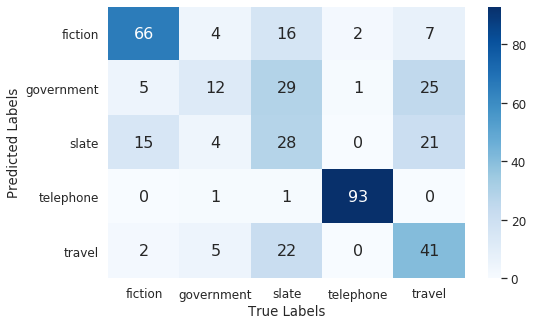

In [45]:
generate_confusion_matrix(labels_test,preds,label_encoder.classes_)